In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, BatchNormalization, LeakyReLU
from keras.layers import concatenate  # Corrected import
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Corrected import for ImageDataGenerator
import tensorflow as tf

# Set the random seeds for reproducibility
tf.random.set_seed(123)
np.random.seed(1)


# Set configuration for TensorFlow session (though eager execution is default in TF 2.x)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Limit GPU memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
print(os.listdir("C:\\Users\\dhuma\\Desktop\\datasets\\dataset_updated"))


ImagePath='C:\\Users\\dhuma\\Desktop\\datasets\\dataset_updated\\training_set\\painting'


['.DS_Store', 'training_set', 'validation_set']


(224, 224, 3)

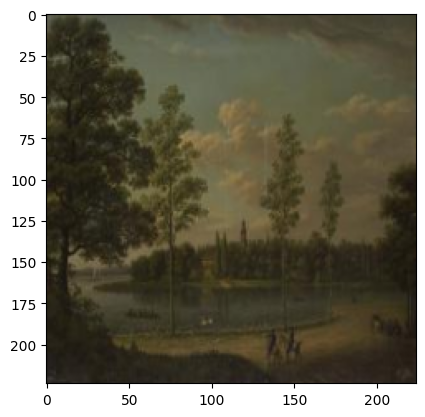

In [2]:
img = cv2.imread(ImagePath+"\\" +"1179.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)
img.shape

In [3]:
'''There are two techniques to generate colored image from its gray scaled form:-

Turn the RGB image into LAB image, then separate the L value and ab value from the image and then train the model to predict the ab value.
Turn the RGB image into LUV image, then separate the L value and UV value from the image and then train the model to predict the UV value.
Here I have used Lab value to colorize the image, where L stands for lightness, and a and b for the color spectra green–red and blue–yellow.**'''

'There are two techniques to generate colored image from its gray scaled form:-\n\nTurn the RGB image into LAB image, then separate the L value and ab value from the image and then train the model to predict the ab value.\nTurn the RGB image into LUV image, then separate the L value and UV value from the image and then train the model to predict the UV value.\nHere I have used Lab value to colorize the image, where L stands for lightness, and a and b for the color spectra green–red and blue–yellow.**'

In [4]:
# Define constants
HEIGHT = 224
WIDTH = 224
ImagePath = 'C:\\Users\\dhuma\\Desktop\\datasets\\dataset_updated\\training_set\\painting'

def ExtractInput(path):
    X_img = []
    y_img = []
    
    # Loop through all images in the directory
    for image_file in os.listdir(path):
        image_path = os.path.join(path, image_file)
        
        try:
            # Read the image
            img = cv2.imread(image_path)
            if img is None:
                print(f"Image {image_file} could not be loaded.")
                continue  # Skip if the image couldn't be loaded
            
            # Convert BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Convert RGB to Lab color space
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

            # Resize the image to match the input size of the network
            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT))

            # Extract the L (lightness) channel and the ab channels
            img_l = img_lab_rs[:, :, 0]  # L channel (lightness)
            img_ab = img_lab_rs[:, :, 1:]  # ab channels

            # Normalize L channel (0 to 1) and ab channels (-1 to 1)
            img_l = img_l.astype(np.float32) / 255.0
            img_ab = img_ab.astype(np.float32) / 128.0
            
            # Append the processed image channels to the respective lists
            X_img.append(img_l)
            y_img.append(img_ab)
        
        except Exception as e:
            print(f"Error processing {image_file}: {e}")
            continue
    
    # Convert lists to numpy arrays
    X_img = np.array(X_img)
    y_img = np.array(y_img)

    return X_img, y_img

# Call the function
X_img, y_img = ExtractInput(ImagePath)

Image .DS_Store could not be loaded.
Image 0000.jpg could not be loaded.
Image 0025.jpg could not be loaded.
Image 0050.jpg could not be loaded.
Image 0075.jpg could not be loaded.
Image 0125.jpg could not be loaded.
Image 0150.jpg could not be loaded.
Image 0175.jpg could not be loaded.
Image 0200.jpg could not be loaded.
Image 0225.jpg could not be loaded.
Image 0250.jpg could not be loaded.
Image 0275.jpg could not be loaded.
Image 0325.jpg could not be loaded.
Image 0350.jpg could not be loaded.
Image 0375.jpg could not be loaded.
Image 0400.jpg could not be loaded.
Image 0425.jpg could not be loaded.
Image 0450.jpg could not be loaded.
Image 0475.jpg could not be loaded.
Image 0500.jpg could not be loaded.
Image 0525.jpg could not be loaded.
Image 0550.jpg could not be loaded.
Image 0575.jpg could not be loaded.
Image 0600.jpg could not be loaded.
Image 0625.jpg could not be loaded.
Image 0650.jpg could not be loaded.
Image 0675.jpg could not be loaded.
Image 0700.jpg could not be

In [5]:
# Call the function for preprocessing
X_, y_ = ExtractInput(ImagePath)

Image .DS_Store could not be loaded.
Image 0000.jpg could not be loaded.
Image 0025.jpg could not be loaded.
Image 0050.jpg could not be loaded.
Image 0075.jpg could not be loaded.
Image 0125.jpg could not be loaded.
Image 0150.jpg could not be loaded.
Image 0175.jpg could not be loaded.
Image 0200.jpg could not be loaded.
Image 0225.jpg could not be loaded.
Image 0250.jpg could not be loaded.
Image 0275.jpg could not be loaded.
Image 0325.jpg could not be loaded.
Image 0350.jpg could not be loaded.
Image 0375.jpg could not be loaded.
Image 0400.jpg could not be loaded.
Image 0425.jpg could not be loaded.
Image 0450.jpg could not be loaded.
Image 0475.jpg could not be loaded.
Image 0500.jpg could not be loaded.
Image 0525.jpg could not be loaded.
Image 0550.jpg could not be loaded.
Image 0575.jpg could not be loaded.
Image 0600.jpg could not be loaded.
Image 0625.jpg could not be loaded.
Image 0650.jpg could not be loaded.
Image 0675.jpg could not be loaded.
Image 0700.jpg could not be

In [6]:
from keras.layers import Conv2D, LeakyReLU, BatchNormalization, MaxPooling2D, UpSampling2D, concatenate
from keras import backend as K

# Clear previous session
K.clear_session()

def InstantiateModel(in_):
    # First block
    model_ = Conv2D(16, (3, 3), padding='same', strides=1)(in_)
    model_ = LeakyReLU()(model_)

    # Second block
    model_ = Conv2D(32, (3, 3), padding='same', strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2, 2), padding='same')(model_)

    # Third block
    model_ = Conv2D(64, (3, 3), padding='same', strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2, 2), padding='same')(model_)


    # Create a tensor to concatenate with
    model_ = Conv2D(64, (3, 3), padding='same', strides=1)(model_)
    model_ = LeakyReLU()(model_)

    # Concatenate the model output with the input
    concat_ = concatenate([model_, in_])

    # Further convolutional layers
    model_ = Conv2D(64, (3, 3), padding='same', strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(32, (3, 3), padding='same', strides=1)(model_)
    model_ = LeakyReLU()(model_)

    # Increasing filters and depth
    model_ = Conv2D(128, (3, 3), padding='same', strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(256, (3, 3), padding='same', strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    # Final up-sampling and output
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128, (3, 3), padding='same', strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    return model_


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, MaxPooling2D, UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Clear previous session
K.clear_session()

def InstantiateModel(in_, HEIGHT, WIDTH):
    # First block
    model_ = Conv2D(16, (3, 3), padding='same', strides=1)(in_)
    model_ = LeakyReLU()(model_)

    # Second block
    model_ = Conv2D(32, (3, 3), padding='same', strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2, 2), padding='same')(model_)  # Shape: (HEIGHT/2, WIDTH/2, 32)

    # Third block
    model_ = Conv2D(64, (3, 3), padding='same', strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2, 2), padding='same')(model_)  # Shape: (HEIGHT/4, WIDTH/4, 64)

    # Up-sampling back to (HEIGHT/2, WIDTH/2, 32)
    model_ = UpSampling2D((2, 2))(model_)

    # Concatenate with the input after ensuring shapes match
    # Option 1: Crop in_transformed to match model_ shape
    cropped_in = tf.keras.layers.Cropping2D(cropping=((HEIGHT // 4, HEIGHT // 4), (WIDTH // 4, WIDTH // 4)))(in_)
    concat_ = Concatenate()([model_, cropped_in])

    # Option 2: Use UpSampling2D on model_
    # up_model = UpSampling2D((HEIGHT // 4, WIDTH // 4))(model_)
    # concat_ = Concatenate()([up_model, in_transformed])

    # Continue with further convolutions
    model_ = Conv2D(64, (3, 3), padding='same', strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(32, (3, 3), padding='same', strides=1)(model_)
    model_ = LeakyReLU()(model_)

    # Final convolutions to upsample back to original input size
    model_ = UpSampling2D((2, 2))(model_)  # Adjusting back to (HEIGHT/2, WIDTH/2, 32)
    model_ = Conv2D(16, (3, 3), padding='same', strides=1)(model_)
    model_ = LeakyReLU()(model_)

    # Final layer to match the input shape
    model_ = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(model_)  # Assuming single channel output

    return model_

# Define input shape
HEIGHT = 224  # Replace with your actual image height
WIDTH = 224 # Replace with your actual image width
Input_Sample = Input(shape=(HEIGHT, WIDTH, 1))

# Instantiate the model
Output_ = InstantiateModel(Input_Sample, HEIGHT, WIDTH)

# Create the colorization model
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

# Set learning rate
LEARNING_RATE = 0.001

# Compile the model
Model_Colourization.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                              loss='mean_squared_error')

# Display model summary
Model_Colourization.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 224, 224,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      4,640 │ leaky_re_lu[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 224, 224,  │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ leaky_re_lu_1[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 112, 112,  │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ leaky_re_lu_2[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 112, 112,  │          0 │ max_pooling2d_1[… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping2d          │ (None, 112, 112,  │          0 │ input_layer[0][0] │
│ (Cropping2D)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 112, 112,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 65)               │            │ cropping2d[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │     37,504 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 112, 112,  │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ leaky_re_lu_3[0]

 Total params: 84,545 (330.25 KB)

 Trainable params: 84,225 (329.00 KB)

 Non-trainable params: 320 (1.25 KB)

In [8]:
def GenerateInputs(X_, y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1, 224, 224, 1)  # Ensure input shape is correct
        y_input = y_[i].reshape(1, 224, 224, 2)  # Ensure output shape is correct
        yield (X_input, y_input)

# Fit the model using the generator
Model_Colourization.fit(GenerateInputs(X_, y_), 
                        epochs=53, 
                        verbose=1, 
                        steps_per_epoch=len(X_) // 1,  # You can adjust the steps per epoch as needed
                        shuffle=True)  # If validation data is needed, you can uncomment the next line
                        # validation_data=GenerateInputs(X_val, y_val))

Epoch 1/53
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 213s 102ms/step - loss: 0.0152
Epoch 2/53
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - loss: 0.0000e+00
Epoch 3/53
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 0s 24us/step - loss: 0.0000e+00
Epoch 4/53
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - loss: 0.0000e+00
Epoch 5/53
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - loss: 0.0000e+00
Epoch 6/53
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - loss: 0.0000e+00
Epoch 7/53
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - loss: 0.0000e+00
Epoch 8/53


c:\Users\dhuma\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2042/2042 ━━━━━━━━━━━━━━━━━━━━ 0s 16us/step - loss: 0.0000e+00
Epoch 9/53
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - loss: 0.0000e+00
Epoch 10/53
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step - loss: 0.0000e+00
Epoch 11/53
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 0s 24us/step - loss: 0.0000e+00
Epoch 12/53
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - loss: 0.0000e+00
Epoch 13/53
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 0s 22us/step - loss: 0.0000e+00
Epoch 14/53
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 0s 18us/step - loss: 0.0000e+00
Epoch 15/53
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 0s 23us/step - loss: 0.0000e+00
Epoch 16/53
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - loss: 0.0000e+00
Epoch 17/53
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 0s 17us/step - loss: 0.0000e+00
Epoch 18/53
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 0s 25us/step - loss: 0.0000e+00
Epoch 19/53
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 0s 23us/step - loss: 0.0000e+00
Epoch 20/53
2042/2042 ━━━━━━━━━━━━━━━━━━━━ 0s 14us/step - loss: 0.0000e+00
Epoch 21/53
2042/2042 ━━━━━━━━━━━━━━━━

In [10]:
TestImagePath="C:\\Users\\dhuma\\Desktop\\datasets\\dataset_updated\\training_set\\iconography"

In [11]:
def ExtractTestInput(ImagePath):
    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert grayscale back to RGB
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)  # Convert to LAB color space
    img_ = img_.astype(np.float32)  # Convert to float32 for processing
    
    # Resize the image to the network input size
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT))  
    img_l = img_lab_rs[:, :, 0]  # Pull out the L channel
    
    # Reshape to match model input shape (1, HEIGHT, WIDTH, 1)
    img_l_reshaped = img_l.reshape(1,224,224,1)  
    
    return img_l_reshaped

In [12]:
ImagePath=TestImagePath+"\\"+ "15.jpg"
image_for_test = ExtractTestInput(ImagePath)
# Predict the colorization
Prediction = Model_Colourization.predict(image_for_test)

# Scale the prediction values
Prediction = Prediction * 128

# Reshape the prediction to (HEIGHT, WIDTH, 2)
Prediction = Prediction.reshape(1,224,224,1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


In [13]:
ImagePath=TestImagePath+"\\"+"15.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*128
Prediction=Prediction.reshape(224,224,1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


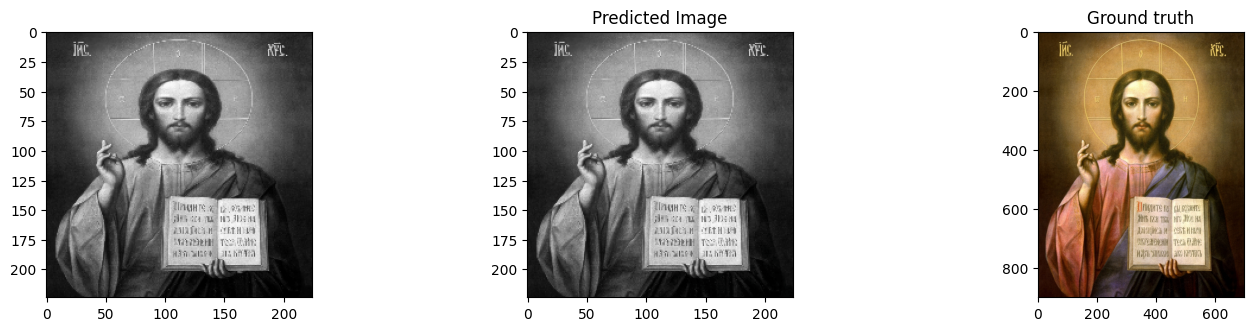

In [14]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+ "\\"+"15.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [15]:
ImagePath=TestImagePath+"\\"+"314.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction_1 = Model_Colourization.predict(image_for_test)
Prediction_1 = Prediction_1*128
Prediction_1=Prediction_1.reshape(224,224,1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


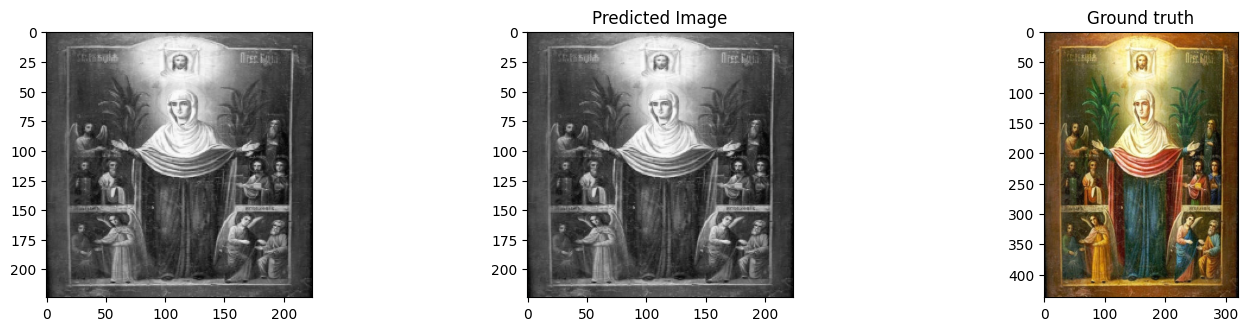

In [16]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"\\"+"314.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_1
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [17]:
ImagePath=TestImagePath+"\\"+"698.jpg"
image_for_test = ExtractTestInput(ImagePath)
Prediction_2 = Model_Colourization.predict(image_for_test)
Prediction_2 = Prediction_2*128
Prediction_2=Prediction_2.reshape(224,224,1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


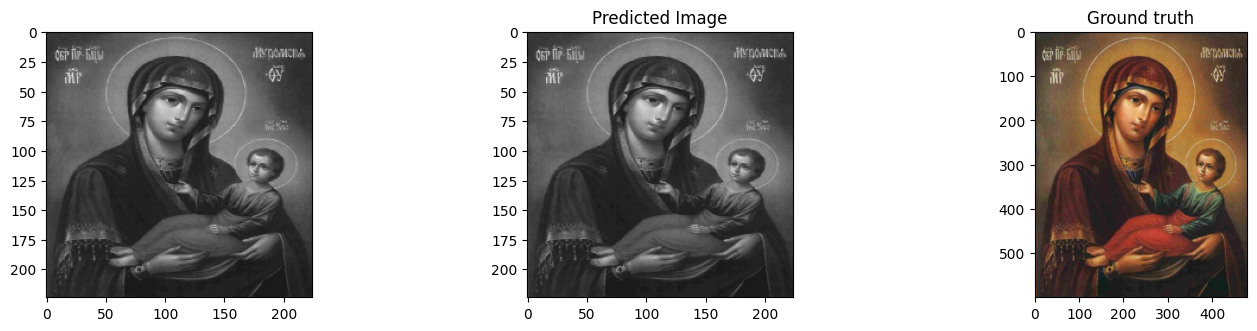

In [18]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"\\"+"698.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_2
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [19]:
TestImagePath="C:\\Users\\dhuma\\Desktop\\datasets\\dataset_updated\\training_set\\sculpture\\240.jpg"
image_for_test = ExtractTestInput(TestImagePath)
Prediction_3 = Model_Colourization.predict(image_for_test)
Prediction_3 = Prediction_3*128
Prediction_3=Prediction_3.reshape(224,224,1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


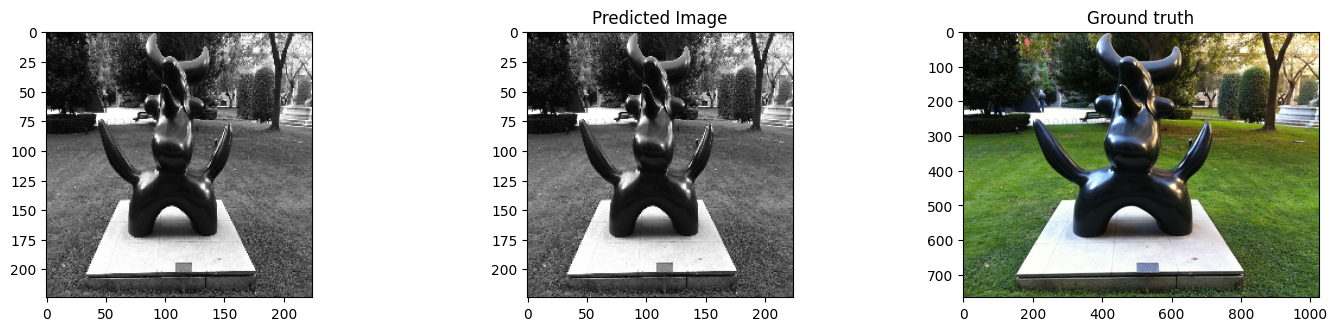

In [20]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_3
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [21]:
TestImagePath="C:\\Users\\dhuma\\Desktop\\datasets\\dataset_updated\\training_set\\painting\\1601.jpg"
image_for_test = ExtractTestInput(TestImagePath)
Prediction_4 = Model_Colourization.predict(image_for_test)
Prediction_4 = Prediction_4*128
Prediction_4=Prediction_4.reshape(224,224,1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


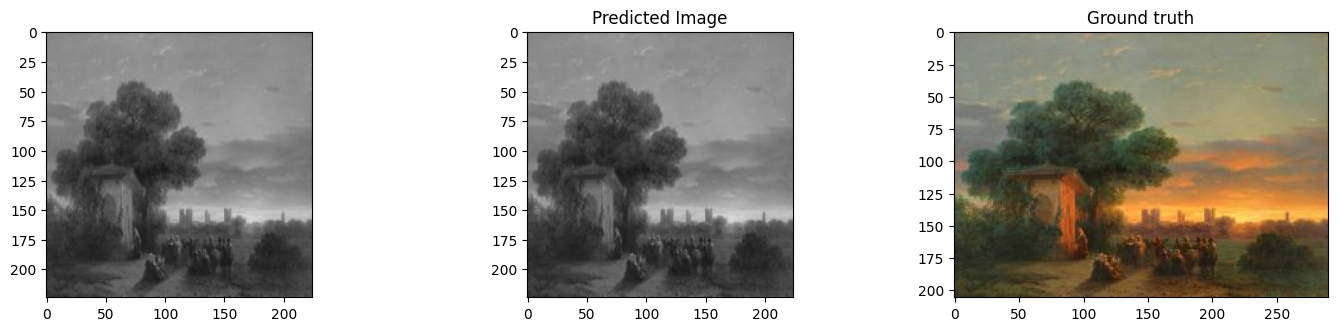

In [22]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_4
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

In [23]:
TestImagePath="C:\\Users\\dhuma\\Desktop\\datasets\\dataset_updated\\training_set\\painting\\1577.jpg"
image_for_test = ExtractTestInput(TestImagePath)
Prediction_5 = Model_Colourization.predict(image_for_test)
Prediction_5 = Prediction_5*128
Prediction_5=Prediction_5.reshape(224,224,1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


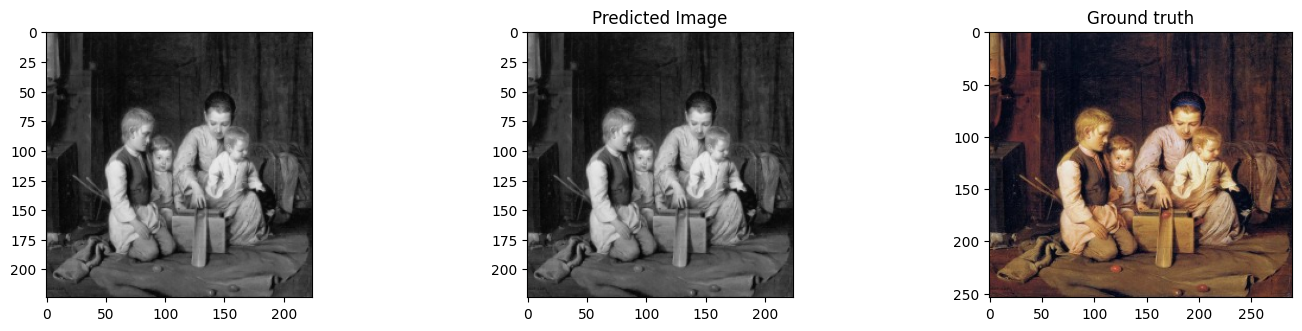

In [24]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction_5
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)